In [1]:
#assume once joined PCG always in - correct?? 0,0,1100,1300,0,0,1200 - assuming middle 0's are still in no raised
import numpy as np
import pandas as pd
from linearmodels import PanelOLS
import statsmodels.api as sm
from scipy import stats

In [2]:
df_New_Main = pd.read_excel('TAMU_NewForm_Main_20170817.xlsx')
df_Old_Main = pd.read_excel('TAMU_OldForm_Main_20170817.xlsx')
df_PCG_Data = pd.read_csv('PCG_Donor_Data2.csv')

#do all renaming here
df_PCG_All = df_PCG_Data.rename(index=str, columns = {"Unnamed: 0" : "org_name"})
df_Old_All = df_Old_Main.rename(index=str, columns = {"ein" : "EIN"})[['org_name', 'EIN', 'FiscalYearEnd',
                                                      'NTEECODE', 'government_grants', 
                                                      'service_revenue', 'membership_dues', 'fundraising']]
df_New_All = df_New_Main.rename(index=str, columns = {"ORGNAME" : "org_name"})[['org_name', 'EIN', 'FiscalYearEnd', 
                                                      'NTEECODE', 'FED_CAMPAIGNS', 'MEMBERSHIP_DUES', 
                                                      'TOTAL_FUNDRAISING', 'RELATED_ORGS', 'GOV_GRANTS', 'CONTRIB_OTHER', 
                                                      'CONTRIB_NONCASH', 'CONTRIB_ALL', 'SERVICE_REVENUE']].rename(index=str, columns = {"MEMBERSHIP_DUES" : "membership_dues", 
                                                                           "GOV_GRANTS" : "government_grants", 
                                                                           "SERVICE_REVENUE" : "service_revenue", "TOTAL_FUNDRAISING" : "fundraising"})

#aggregate summing of repeated EINs
df_PCG_All.loc[df_PCG_All['EIN'] == '23-7394620', 'org_name'] = 'University of Alaska'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0155067', 'org_name'] = 'Alaska Community Foundation'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0152088', 'org_name'] = 'Alaska Medical Missions CHA'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-6001185', 'org_name'] = 'Crime Victim Compensation Fund'
df_PCG_All = df_PCG_All.groupby(['EIN','org_name'], as_index = False).sum()
#grouped so each EIN appears 1 time
#604 unique organizations by EIN (df_PCG_All['EIN'].nunique())
#new is 2007 - 2015
#old is 1998 - 2008
df_New = df_New_All[['EIN', 'FiscalYearEnd', 'membership_dues', 
                                    'government_grants', 'service_revenue', 'fundraising']].fillna(0)
df_Old = df_Old_All[['EIN', 'FiscalYearEnd', 'membership_dues', 
                                    'government_grants', 'service_revenue', 'fundraising']].fillna(0)
df_PCG = pd.melt(df_PCG_All, id_vars=['EIN', 'org_name'], value_vars=['2009','2010','2011','2012','2013',
                                    '2014','2015','2016','2017','2018'], var_name = 'FiscalYearEnd', value_name = 'Raised')
df_PCG['FiscalYearEnd'] = df_PCG['FiscalYearEnd'].astype(int)
df_OldNew = pd.concat([df_New, df_Old], ignore_index = True)

#assume year started is min year where raised > 0
df_PCG_NOZERO = df_PCG[df_PCG['Raised'] != 0]
df_PCG_Start = df_PCG_NOZERO.groupby('EIN', as_index=False)['FiscalYearEnd'].min().rename(index=str, columns = {"FiscalYearEnd": "PCGStartYear"})

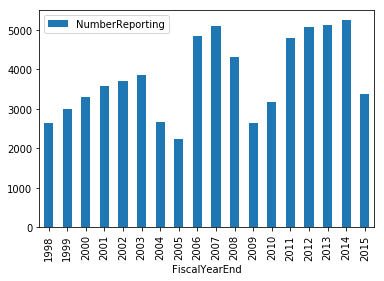

In [3]:
df_YearReporting = df_OldNew.groupby('FiscalYearEnd')['EIN'].count().reset_index(name='NumberReporting')
plt = df_YearReporting.plot.bar(x='FiscalYearEnd',y='NumberReporting')

In [4]:
#want year reporting to have column = numbe of reporting that are in pcg

In [5]:
df_Years = pd.concat([df_PCG[['EIN','FiscalYearEnd']], df_OldNew[['EIN','FiscalYearEnd']]]).drop_duplicates()

In [6]:
df_Years_Start = df_Years.merge(df_PCG_Start, how = 'left', on='EIN')

In [7]:
df_Years_Start['in_PCG'] = (df_Years_Start['FiscalYearEnd']  >= df_Years_Start['PCGStartYear']).astype(int)

In [8]:
df_All_Years = pd.merge(df_Years_Start, df_OldNew[['EIN','FiscalYearEnd']], on =['EIN','FiscalYearEnd'], 
         how='left', indicator='IRS_Report')

In [9]:
df_All_Years['IRS_Report'] = (df_All_Years['IRS_Report'] == 'both').astype(int)

In [10]:
#df_All_Years[(df_All_Years['in_PCG'] == 1) & (df_All_Years['IRS_Report'] == 1)]

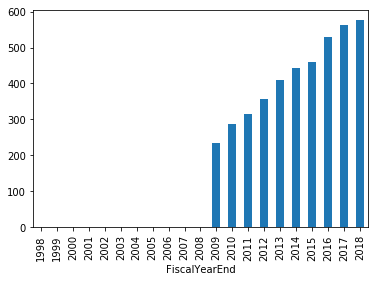

In [11]:
plt = df_All_Years.groupby('FiscalYearEnd')['in_PCG'].sum().plot.bar(x='FiscalYearEnd',y=['unnamed'])

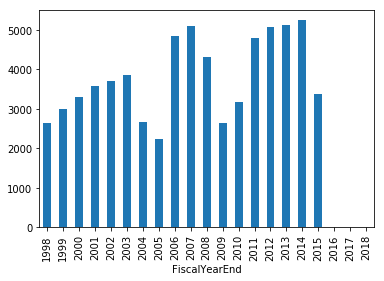

In [12]:
plt = df_All_Years.groupby('FiscalYearEnd')['IRS_Report'].sum().plot.bar(x='FiscalYearEnd',y=['unnamed'])

In [17]:
df_All_IRS = df_All_Years[df_All_Years['IRS_Report'] == 1]

In [19]:
df_All_IRS.groupby('FiscalYearEnd')['in_PCG'].sum()

FiscalYearEnd
1998      0
1999      0
2000      0
2001      0
2002      0
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009    128
2010    167
2011    212
2012    237
2013    253
2014    280
2015    183
Name: in_PCG, dtype: int64

In [22]:
df_PCT_PCG = df_YearReporting.merge(df_All_IRS.groupby('FiscalYearEnd')['in_PCG'].sum(), how = 'left', on='FiscalYearEnd')

In [26]:
df_PCT_PCG['pct_PCG'] = df_PCT_PCG['in_PCG']/df_PCT_PCG['NumberReporting']

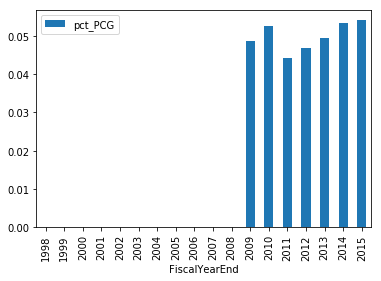

In [28]:
plt = df_PCT_PCG.plot.bar(x='FiscalYearEnd', y='pct_PCG')

In [27]:
df_PCT_PCG.head(1)

,FiscalYearEnd,NumberReporting,in_PCG,pct_PCG
0,1998,2651,0,0.0
